In [ ]:
! pip install datasets

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import torch
import json
import pandas as pd
import numpy as np
from datasets import load_dataset, load_metric

torch.backends.cuda.max_split_size_mb = 1024
# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
dataset = load_dataset("derek-thomas/ScienceQA")
train_data, val_data = dataset["train"], dataset["validation"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

vit_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)



max_length = 64
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(example):
  images = []
  # for image_path in image_paths:
  #   i_image = Image.open(image_path)
  #   if i_image.mode != "RGB":
  #     i_image = i_image.convert(mode="RGB")
  image = example["image"]
  if image:
    images.append(image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = vit_model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]

    example["captions"] = preds[0]
  else:
    example["captions"] = ""
  return example

In [ ]:
#Mapping the predict_step function to generate image captions for training set
train_data_captions = train_data.map(predict_step)

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

In [ ]:
#Mapping the predict_step function to generate image captions for training set
val_data_captions = val_data.map(predict_step)

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [ ]:
train_data_captions[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=750x429 at 0x7FC0247F10A0>,
 'question': 'Which of these states is farthest north?',
 'choices': ['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma'],
 'answer': 0,
 'hint': '',
 'task': 'closed choice',
 'grade': 'grade2',
 'subject': 'social science',
 'topic': 'geography',
 'category': 'Geography',
 'skill': 'Read a map: cardinal directions',
 'lecture': 'Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\nThe north arrow points to the North Pole. On most maps, north is at the top of the map.',
 'solution': 'To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.',
 'captions': 'an aerial view of a painting of a forest'}

In [12]:
val_data_captions[12]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=202x202 at 0x7FBE602797F0>,
 'question': 'Is Lithops bromfieldii made up of many cells?',
 'choices': ['yes', 'no'],
 'answer': 0,
 'hint': 'This organism is Lithops bromfieldii. It is a member of the plant kingdom.\nLithops bromfieldii lives in South Africa. Each L. bromfieldii is made up of two brown or gray leaves. Because of its unusual appearance, L. bromfieldii is sometimes called a living stone.',
 'task': 'yes or no',
 'grade': 'grade5',
 'subject': 'natural science',
 'topic': 'biology',
 'category': 'Classification',
 'skill': 'Describe, classify, and compare kingdoms',
 'lecture': 'In the past, scientists classified living organisms into two groups: plants and animals. Over the past 300 years, scientists have discovered many more types of organisms. Today, many scientists classify organisms into six broad groups, called kingdoms.\nOrganisms in each kingdom have specific traits. The table below shows some traits u

In [65]:
# Define the model and tokenizer

model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

In [66]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [67]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [68]:
train_data_captions_dict = train_data_captions.to_dict()
val_data_captions_dict = val_data_captions.to_dict()

In [15]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

In [16]:
with open('./train_captionsdata.pickle', 'wb') as handle:
    pickle.dump(train_data_captions_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('./val_captionsdata.pickle', 'wb') as handle:
    pickle.dump(val_data_captions_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
import datasets

In [19]:
train_data_captions = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data_captions_dict))
val_data_captions = datasets.Dataset.from_pandas(pd.DataFrame(data=val_data_captions_dict))

In [ ]:
train_data_captions[0]

In [21]:
# process the examples in input and target text format and the eos token at the end 

#For answer ONLY (not solution and explanation and knowledge)
def add_eos_to_examples(example):
    example['input_text'] = 'Question: %s  Choices: %s  Context: %s </s>' % (example['captions']+". "+example['question'].lower(), example['choices'], example['skill'].lower()+example['hint'].lower())
    example['target_text'] = 'Answer: %s  Explanation: %s Knowledge: %s </s>' % (example['choices'][example['answer']], example['solution'], example['lecture'])
    return example

# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input_text'], pad_to_max_length=True, max_length=512, truncation=True)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target_text'], pad_to_max_length=True, max_length=256, truncation=True)

    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'target_ids': target_encodings['input_ids'],
        'target_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [71]:
# process the examples in input and target text format and the eos token at the end 

#For answer ONLY (not solution and explanation)
def add_eos_to_examples(example):
    example['input_text'] = 'question %s  choices: %s  context: %s </s>' % (example['captions'].lower()+". "+example['question'].lower(), example['choices'], example['skill'].lower()+example['hint'].lower())
    example['target_text'] = 'answer: %s  explanation: %s </s>' % (example['choices'][example['answer']], example['solution'])
    return example

# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input_text'], pad_to_max_length=True, max_length=512, truncation=True)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target_text'], pad_to_max_length=True, max_length=256, truncation=True)

    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'target_ids': target_encodings['input_ids'],
        'target_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [72]:
# map add_eos_to_examples function to the dataset example wise 
train_dataset = train_data_captions.map(add_eos_to_examples)
# map convert_to_features batch wise
train_dataset = train_dataset.map(convert_to_features, batched=True)
valid_dataset = val_data_captions.map(add_eos_to_examples, load_from_cache_file=False)
valid_dataset = valid_dataset.map(convert_to_features, batched=True, load_from_cache_file=False)

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [73]:
# set the tensor type and the columns which the dataset should return
columns = ['input_ids', 'target_ids', 'attention_mask', 'target_attention_mask']
train_dataset.set_format(type='torch', columns=columns)
valid_dataset.set_format(type='torch', columns=columns)

In [74]:
len(train_dataset), len(valid_dataset)

(12726, 4241)

In [75]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [76]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['input_ids', 'attention_mask', 'target_ids', 'target_attention_mask'])


In [77]:
tokenizer.decode(batch['input_ids'][7])

'question. which sentence states a fact? choices: [\'Jeff Kinney worked on Diary of a Wimpy Kid for six years before publishing it online.\', "Cartoonist Jeff Kinney\'s book Diary of a Wimpy Kid deserves all of the praise it has received."] context: distinguish facts from opinions</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [78]:
tokenizer.decode(batch['target_ids'][7])

"answer: Jeff Kinney worked on Diary of a Wimpy Kid for six years before publishing it online. explanation: The first sentence states a fact. Jeff Kinney worked on Diary of a Wimpy Kid for six years before publishing it online. It can be proved by reading a biography of Jeff Kinney. The second sentence states an opinion. Cartoonist Jeff Kinney's book Diary of a Wimpy Kid deserves all of the praise it has received. Deserves shows what a person believes, thinks, or feels. Another person might have a different opinion about how much praise Diary of a Wimpy Kid deserves.</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [79]:
from transformers import DataCollator, AdamW, get_linear_schedule_with_warmup
import numpy as np

In [80]:
def data_collator(batch):
    input_ids = torch.stack([example['input_ids'] for example in batch])
    attention_mask = torch.stack([example['attention_mask'] for example in batch])

    target_ids = torch.stack([example['target_ids'] for example in batch])
    target_attention_mask = torch.stack([example['target_attention_mask'] for example in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'target_ids': target_ids,
        'target_attention_mask': target_attention_mask
    }

In [81]:
from tqdm import tqdm
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = 10000
num_warmup_steps = 500
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# Define the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loss = []
val_loss = []
for epoch in range(10):
    print("Training: ")
    model.train(True)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=target_ids,
            decoder_attention_mask=target_attention_mask,
            use_cache=False
        )
        
        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    train_loss.append(total_loss / len(train_dataloader))
    print(train_loss)

    print("Validation Loss:")
    valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target_ids = batch['target_ids'].to(device)
            target_attention_mask = batch['target_attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=target_ids,
                decoder_attention_mask=target_attention_mask,
                use_cache=False
            )

            loss = outputs.loss
            total_loss += loss.item()
    val_loss.append(total_loss / len(valid_dataloader))
    print(val_loss)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training: 


100%|██████████| 1591/1591 [11:10<00:00,  2.37it/s]


[2.4266336751782167]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.00it/s]


[0.5100782163328932]
Training: 


100%|██████████| 1591/1591 [11:12<00:00,  2.37it/s]


[2.4266336751782167, 0.5565322090916706]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.01it/s]


[0.5100782163328932, 0.4418206668569375]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.01it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.01it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136, 0.4580190743546228]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.02it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323, 0.37160126145985223]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136, 0.4580190743546228, 0.4491763937162349]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.02it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323, 0.37160126145985223, 0.3662923008813865]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136, 0.4580190743546228, 0.4491763937162349, 0.446949678437467]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.01it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323, 0.37160126145985223, 0.3662923008813865, 0.36599101218098523]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136, 0.4580190743546228, 0.4491763937162349, 0.446949678437467, 0.44610042390978466]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.02it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323, 0.37160126145985223, 0.3662923008813865, 0.36599101218098523, 0.36599101218098523]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136, 0.4580190743546228, 0.4491763937162349, 0.446949678437467, 0.44610042390978466, 0.44720541708766104]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.02it/s]


[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323, 0.37160126145985223, 0.3662923008813865, 0.36599101218098523, 0.36599101218098523, 0.36599101218098523]
Training: 


100%|██████████| 1591/1591 [11:13<00:00,  2.36it/s]


[2.4266336751782167, 0.5565322090916706, 0.5045623070250735, 0.47556018877580136, 0.4580190743546228, 0.4491763937162349, 0.446949678437467, 0.44610042390978466, 0.44720541708766104, 0.4466471730641866]
Validation Loss:


100%|██████████| 531/531 [01:15<00:00,  7.01it/s]

[0.5100782163328932, 0.4418206668569375, 0.4055450669158313, 0.3841096995812323, 0.37160126145985223, 0.3662923008813865, 0.36599101218098523, 0.36599101218098523, 0.36599101218098523, 0.36599101218098523]


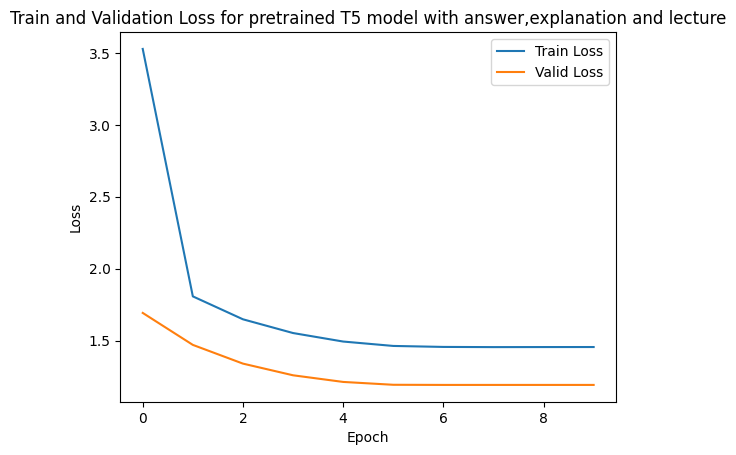

In [62]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss for pretrained T5 model with answer,explanation and lecture')
plt.show()

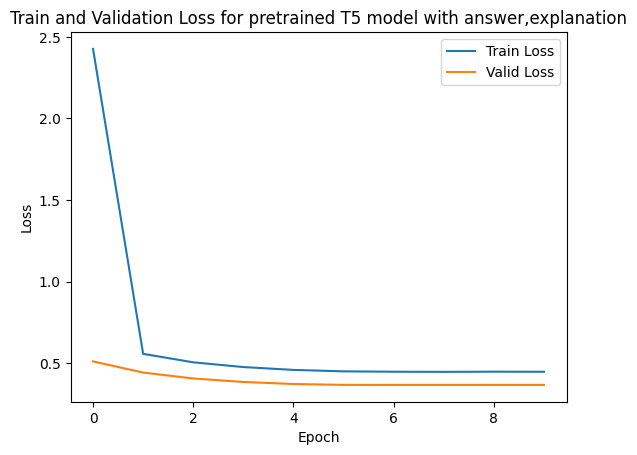

In [82]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss for pretrained T5 model with answer,explanation')
plt.show()

In [83]:
# model with answer and explanation
model.save_pretrained("./model_3_pretrained_ans_exp_new", from_pt=True)

In [47]:
model=T5ForConditionalGeneration.from_pretrained('./model_3_pretrained_ans_exp').to(device)

In [61]:
model.save_pretrained("./model_3_pretrained_ans_exp_lecture", from_pt=True)

In [84]:
with open('./train_loss_model3', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [85]:
with open('./val_loss_model2', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=5783fbfedfb35acb535e91764ad28939f37ce4ba0b7c863e7f9231efc60f83bb
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score


In [87]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer
import string

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
smoothie = SmoothingFunction().method4

model.eval()
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=data_collator)

model_answers_train = []
target_answers_train = []

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            # decoder_attention_mask=target_attention_mask,
            max_length=512,
            num_beams=10,
            early_stopping=True
        )
        
        # Convert the generated output to text
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_text = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        # print(output_text)
        # print("--")
        # print(target_text)
        model_answers_train.append(output_text)
        target_answers_train.append(target_text)

100%|██████████| 1591/1591 [58:36<00:00,  2.21s/it]


In [88]:
with open('./results/model3_answers_train', 'wb') as handle:
    pickle.dump(model_answers_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./results/model3_target_answers_train', 'wb') as handle:
    pickle.dump(target_answers_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Metrics on Training Set**

In [89]:
model_answers_train_overall,target_answers_train_overall=sum(model_answers_train,[]),sum(target_answers_train,[])

In [90]:
accuracy_boolean_train=[a.lower().split("explanation:")[0].strip()==b.lower().split("explanation:")[0].strip() for a,b in zip((model_answers_train_overall),(target_answers_train_overall))]

In [91]:
acc_train=(sum(accuracy_boolean_train)/len(accuracy_boolean_train))*100
print(f"The training accuracy of the model is {acc_train:.2f} %")

The training accuracy of the model is 41.32 %


In [92]:
exp_bleu_score_train = []
exp_precision_rouge1_score_train = []
exp_recall_rouge1_score_train = []
exp_precision_rouge2_score_train = []
exp_recall_rouge2_score_train = []
exp_precision_rougeL_score_train = []
exp_recall_rougeL_score_train = []

def compute_metrics(model_output,target_output):
    out_exp,tar_exp=model_output.split("explanation:")[1].strip(),target_output.split("explanation:")[1].strip()
    exp_bleu_score_train.append(sentence_bleu(tar_exp.split(), out_exp.split(), smoothing_function=smoothie))
    exp_recall_rouge1_score_train.append(scorer.score(tar_exp, out_exp)['rouge1'][1])
    exp_precision_rouge1_score_train.append(scorer.score(tar_exp, out_exp)['rouge1'][0])
    exp_recall_rouge2_score_train.append(scorer.score(tar_exp, out_exp)['rouge2'][1])
    exp_precision_rouge2_score_train.append(scorer.score(tar_exp, out_exp)['rouge2'][0])
    exp_recall_rougeL_score_train.append(scorer.score(tar_exp, out_exp)['rougeL'][1])
    exp_precision_rougeL_score_train.append(scorer.score(tar_exp, out_exp)['rougeL'][0])
    return

In [93]:
for a,b in zip(model_answers_train_overall,target_answers_train_overall):  
    try:
        compute_metrics(a,b)
    except:
        pass

In [94]:
print("Training Metrics:")
print("--")
print("For Explanation: ")
print(f"Bleu Score: {np.array(exp_bleu_score_train).mean()}")
print(f"Rouge-1 Precision Score: {np.array(exp_precision_rouge1_score_train).mean()}")
print(f"Rouge-1 Recall Score: {np.array(exp_recall_rouge1_score_train).mean()}")
print(f"Rouge-2 Precision Score: {np.array(exp_precision_rouge2_score_train).mean()}")
print(f"Rouge-2 Recall Score: {np.array(exp_recall_rouge2_score_train).mean()}")
print(f"Rouge-L Precision Score: {np.array(exp_precision_rougeL_score_train).mean()}")
print(f"Rouge-L Recall Score: {np.array(exp_recall_rougeL_score_train).mean()}")


Training Metrics:
--
For Explanation: 
Bleu Score: 0.005251760801924401
Rouge-1 Precision Score: 0.5848276595481626
Rouge-1 Recall Score: 0.3142535222630806
Rouge-2 Precision Score: 0.43367049611427366
Rouge-2 Recall Score: 0.227123027719215
Rouge-L Precision Score: 0.535503526273039
Rouge-L Recall Score: 0.28908061672137564


Model generation for validation dataset

In [95]:
# Evaluate the model on the validation set
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer
import string

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
smoothie = SmoothingFunction().method4

model.eval()
valid_dataloader = DataLoader(valid_dataset, batch_size=8, collate_fn=data_collator)

model_answers = []
target_answers = []

with torch.no_grad():
    for batch in tqdm(valid_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            # decoder_attention_mask=target_attention_mask,
            max_length=512,
            num_beams=10,
            early_stopping=True
        )
        
        # Convert the generated output to text
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_text = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        model_answers.append(output_text)
        target_answers.append(target_text)

100%|██████████| 531/531 [19:53<00:00,  2.25s/it]


In [96]:
with open('./results/model_3_model_answers_valid', 'wb') as handle:
    pickle.dump(model_answers, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./results/model_3_target_answers_valid', 'wb') as handle:
    pickle.dump(target_answers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
model_answers_valid_overall,target_answers_valid_overall=sum(model_answers,[]),sum(target_answers,[])

In [99]:
accuracy_boolean_valid=[a.lower().split("explanation:")[0].strip()==b.lower().split("explanation:")[0].strip() for a,b in zip((model_answers_valid_overall),(target_answers_valid_overall))]

Metrics on Validation Set

In [100]:
acc_train=(sum(accuracy_boolean_valid)/len(accuracy_boolean_valid))*100
print(f"The validation accuracy of the model is {acc_train:.2f} %")

The validation accuracy of the model is 39.09 %


In [101]:
exp_bleu_score_valid = []
exp_precision_rouge1_score_valid = []
exp_recall_rouge1_score_valid = []
exp_precision_rouge2_score_valid = []
exp_recall_rouge2_score_valid = []
exp_precision_rougeL_score_valid = []
exp_recall_rougeL_score_valid = []

def compute_metrics(model_output,target_output):
    out_exp,tar_exp=model_output.split("explanation:")[1].strip(),target_output.split("explanation:")[1].strip()
    exp_bleu_score_valid.append(sentence_bleu(tar_exp.split(), out_exp.split(), smoothing_function=smoothie))
    exp_recall_rouge1_score_valid.append(scorer.score(tar_exp, out_exp)['rouge1'][1])
    exp_precision_rouge1_score_valid.append(scorer.score(tar_exp, out_exp)['rouge1'][0])
    exp_recall_rouge2_score_valid.append(scorer.score(tar_exp, out_exp)['rouge2'][1])
    exp_precision_rouge2_score_valid.append(scorer.score(tar_exp, out_exp)['rouge2'][0])
    exp_recall_rougeL_score_valid.append(scorer.score(tar_exp, out_exp)['rougeL'][1])
    exp_precision_rougeL_score_valid.append(scorer.score(tar_exp, out_exp)['rougeL'][0])
    return

In [102]:
for a,b in zip(model_answers_valid_overall,target_answers_valid_overall):  
    try:
        compute_metrics(a,b)
    except:
        pass

In [103]:
print("Validation Metrics:")
print("--")
print("For Explanation: ")
print(f"Bleu Score: {np.array(exp_bleu_score_valid).mean()}")
print(f"Rouge-1 Precision Score: {np.array(exp_precision_rouge1_score_valid).mean()}")
print(f"Rouge-1 Recall Score: {np.array(exp_recall_rouge1_score_valid).mean()}")
print(f"Rouge-2 Precision Score: {np.array(exp_precision_rouge2_score_valid).mean()}")
print(f"Rouge-2 Recall Score: {np.array(exp_recall_rouge2_score_valid).mean()}")
print(f"Rouge-L Precision Score: {np.array(exp_precision_rougeL_score_valid).mean()}")
print(f"Rouge-L Recall Score: {np.array(exp_recall_rougeL_score_valid).mean()}")

Validation Metrics:
--
For Explanation: 
Bleu Score: 0.005398851782335754
Rouge-1 Precision Score: 0.5883035903808426
Rouge-1 Recall Score: 0.3214449475044458
Rouge-2 Precision Score: 0.4384909520711954
Rouge-2 Recall Score: 0.23365951093756832
Rouge-L Precision Score: 0.5366650336511921
Rouge-L Recall Score: 0.2946098116906994


**Running the model with adding the generated examples**

In [104]:
gen_exp_train = [i.lower().split("explanation:")[1].strip() if "explanation:" in i.lower() else '' for i in model_answers_train_overall ]

In [105]:
train_data_captions_gen_exp_dict = train_data_captions_dict
train_data_captions_gen_exp_dict["generated_exp"] = gen_exp_train
train_data_captions_gen_exp = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data_captions_gen_exp_dict))

In [106]:
val_data_captions_gen_exp_dict = val_data_captions_dict
gen_exp_val = [i.lower().split("explanation:")[1].strip() if "explanation:" in i.lower() else '' for i in model_answers_valid_overall ]
val_data_captions_gen_exp_dict["generated_exp"] = gen_exp_val
val_data_captions_gen_exp = datasets.Dataset.from_pandas(pd.DataFrame(data=val_data_captions_gen_exp_dict))

In [107]:
len(gen_exp_train),len(gen_exp_val)

(12726, 4241)

In [110]:
# process the examples in input and target text format and the eos token at the end
# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("./models_saved/t5small_answer_model2_512_128_10_8_8").to(device) 
#Change this to the new model from checkpoints.
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
tokenizer = AutoTokenizer.from_pretrained("t5-small")
#For answer with generated explanation in input
def add_eos_to_examples(example):
    example['input_text'] = 'question: %s  choices: %s  context: %s </s>' % (example['captions'].lower()+". "+example['question'].lower(), example['choices'], example['generated_exp']+example['hint'].lower())
    example['target_text'] = 'answer: %s </s>' % (example['choices'][example['answer']])
    return example

# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input_text'], pad_to_max_length=True, max_length=512, truncation=True)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target_text'], pad_to_max_length=True, max_length=128, truncation=True)
    #max_length = 128 when just answer, 256 when answer & explanation, 512 when all three
    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'target_ids': target_encodings['input_ids'],
        'target_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [111]:
#For generated examples as input:

# map add_eos_to_examples function to the dataset example wise 
train_dataset = train_data_captions_gen_exp.map(add_eos_to_examples, load_from_cache_file=False)
# map convert_to_features batch wise
train_dataset = train_dataset.map(convert_to_features, batched=True)

valid_dataset = val_data_captions_gen_exp.map(add_eos_to_examples, load_from_cache_file=False)
valid_dataset = valid_dataset.map(convert_to_features, batched=True, load_from_cache_file=False)


# set the tensor type and the columns which the dataset should return
columns = ['input_ids', 'target_ids', 'attention_mask', 'target_attention_mask']
train_dataset.set_format(type='torch', columns=columns)
valid_dataset.set_format(type='torch', columns=columns)

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [112]:
len(train_dataset), len(valid_dataset)

(12726, 4241)

In [113]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [114]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['input_ids', 'attention_mask', 'target_ids', 'target_attention_mask'])


In [120]:
tokenizer.decode(batch['input_ids'][2])

"question: a blue and white photo of a blue and white bird flying through the air. which month is the coolest on average in detroit? choices: ['November and December', 'January and February', 'March and April'] context: this month is the coolest on average in detroit.use the graph to answer the question below.</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [121]:
tokenizer.decode(batch['target_ids'][7])

'answer: acquired</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [122]:
from transformers import DataCollator, AdamW, get_linear_schedule_with_warmup
import numpy as np

In [123]:
def data_collator(batch):
    input_ids = torch.stack([example['input_ids'] for example in batch])
    attention_mask = torch.stack([example['attention_mask'] for example in batch])

    target_ids = torch.stack([example['target_ids'] for example in batch])
    target_attention_mask = torch.stack([example['target_attention_mask'] for example in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'target_ids': target_ids,
        'target_attention_mask': target_attention_mask
    }

In [124]:
from tqdm import tqdm
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = 10000
num_warmup_steps = 500
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# Define the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loss = []
val_loss = []
for epoch in range(10):
    print("Training: ")
    model.train(True)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=target_ids,
            decoder_attention_mask=target_attention_mask,
            use_cache=False
        )
        
        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    train_epoch_loss = total_loss / len(train_dataloader) 
    train_loss.append(train_epoch_loss)
    print(f"Training Loss at epoch {epoch}: {train_epoch_loss}")

    print("Validation:")
    valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target_ids = batch['target_ids'].to(device)
            target_attention_mask = batch['target_attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=target_ids,
                decoder_attention_mask=target_attention_mask,
                use_cache=False
            )

            loss = outputs.loss
            total_loss += loss.item()
    val_epoch_loss = total_loss / len(valid_dataloader) 
    val_loss.append(val_epoch_loss)
    print(f"Validation Loss at epoch {epoch}: {val_epoch_loss}")
    # val_loss.append(total_loss / len(valid_dataloader))
    # print(val_loss)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training: 


100%|██████████| 1591/1591 [08:38<00:00,  3.07it/s]


Training Loss at epoch 0: 1.8599964403058564
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.94it/s]


Validation Loss at epoch 0: 0.02575551416889787
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.06it/s]


Training Loss at epoch 1: 0.03288339875406679
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.95it/s]


Validation Loss at epoch 1: 0.02105094720048237
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.05it/s]


Training Loss at epoch 2: 0.027657493010589455
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.93it/s]


Validation Loss at epoch 2: 0.019250913794554084
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.05it/s]


Training Loss at epoch 3: 0.025558788917951714
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.93it/s]


Validation Loss at epoch 3: 0.01832215625857636
Training: 


100%|██████████| 1591/1591 [08:41<00:00,  3.05it/s]


Training Loss at epoch 4: 0.0242391327582768
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.94it/s]


Validation Loss at epoch 4: 0.0177090841037679
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.05it/s]


Training Loss at epoch 5: 0.02379588044109789
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.95it/s]


Validation Loss at epoch 5: 0.017482392351790253
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.05it/s]


Training Loss at epoch 6: 0.02327952609414447
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.95it/s]


Validation Loss at epoch 6: 0.01746683108809767
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.06it/s]


Training Loss at epoch 7: 0.02339710072672204
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.95it/s]


Validation Loss at epoch 7: 0.01746683108809767
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.06it/s]


Training Loss at epoch 8: 0.02332303901674199
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.94it/s]


Validation Loss at epoch 8: 0.01746683108809767
Training: 


100%|██████████| 1591/1591 [08:40<00:00,  3.06it/s]


Training Loss at epoch 9: 0.023102040203858348
Validation:


100%|██████████| 531/531 [00:59<00:00,  8.96it/s]

Validation Loss at epoch 9: 0.01746683108809767


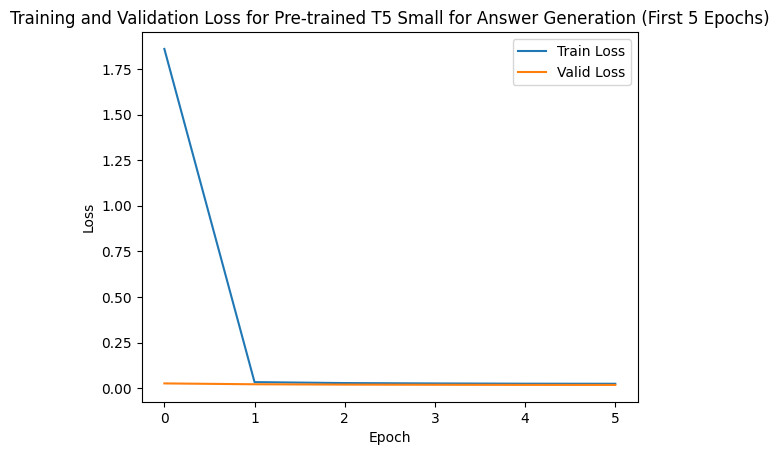

In [140]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_loss[0:6], label='Train Loss')
plt.plot(val_loss[0:6], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss for Pre-trained T5 Small for Answer Generation (First 5 Epochs)")
plt.legend()
plt.show()

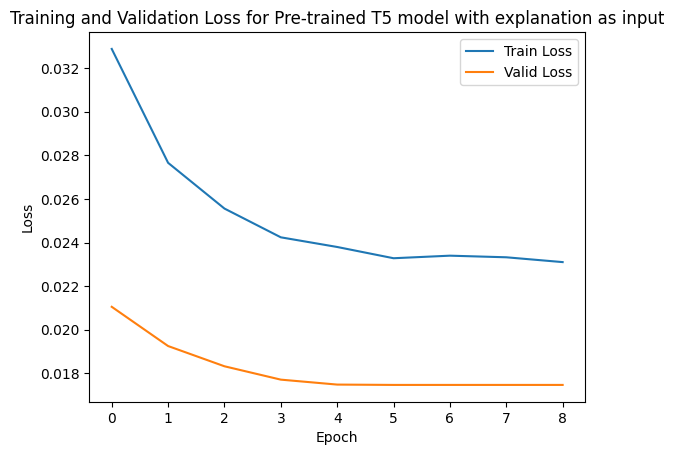

In [127]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(train_loss[1:10], label='Train Loss')
plt.plot(val_loss[1:10], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss for Pre-trained T5 model with explanation as input")
plt.legend()
plt.show()

In [129]:
with open('./train_loss_model3', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./val_loss_model3', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [130]:
model.save_pretrained("model_5_generated_exp", from_pt=True)

In [131]:
# Evaluate the model on the train set
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer
import string

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
smoothie = SmoothingFunction().method4

model.eval()
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=data_collator)

model_answers_train = []
target_answers_train = []

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            # decoder_attention_mask=target_attention_mask,
            max_length=512,
            num_beams=10,
            early_stopping=True
        )
        
        # Convert the generated output to text
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_text = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        # print(output_text)
        # print("--")
        # print(target_text)
        model_answers_train.append(output_text)
        target_answers_train.append(target_text)

100%|██████████| 1591/1591 [18:23<00:00,  1.44it/s]


In [132]:
with open('./results/model5_answers_train', 'wb') as handle:
    pickle.dump(model_answers_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./results/model5_target_answers_train', 'wb') as handle:
    pickle.dump(target_answers_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

Metrics on Training Set

In [133]:
model_answers_train_overall,target_answers_train_overall=sum(model_answers_train,[]),sum(target_answers_train,[])
accuracy_boolean_train=[a.lower().split("explanation:")[0].strip()==b.lower().split("explanation:")[0].strip() for a,b in zip((model_answers_train_overall),(target_answers_train_overall))]
acc_train=(sum(accuracy_boolean_train)/len(accuracy_boolean_train))*100
print(f"The training accuracy of the model is {acc_train:.2f} %")

The training accuracy of the model is 45.01 %


Validation Dataset

In [137]:
# Evaluate the model on the validation set
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer
import string

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=tokenizer)
smoothie = SmoothingFunction().method4

model.eval()
valid_dataloader = DataLoader(valid_dataset, batch_size=8, collate_fn=data_collator)

model_answers = []
target_answers = []

with torch.no_grad():
    for batch in tqdm(valid_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target_ids = batch['target_ids'].to(device)
        target_attention_mask = batch['target_attention_mask'].to(device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            # decoder_attention_mask=target_attention_mask,
            max_length=512,
            num_beams=10,
            early_stopping=True
        )
        
        # Convert the generated output to text
        output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        target_text = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        model_answers.append(output_text)
        target_answers.append(target_text)

100%|██████████| 531/531 [06:08<00:00,  1.44it/s]


In [138]:
with open('./results/model_5_model_answers_valid', 'wb') as handle:
    pickle.dump(model_answers, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./results/model_5_target_answers_valid', 'wb') as handle:
    pickle.dump(target_answers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [139]:
model_answers_valid_overall,target_answers_valid_overall=sum(model_answers,[]),sum(target_answers,[])
accuracy_boolean_valid=[a.lower().split("explanation:")[0].strip()==b.lower().split("explanation:")[0].strip() for a,b in zip((model_answers_valid_overall),(target_answers_valid_overall))]
acc_train=(sum(accuracy_boolean_valid)/len(accuracy_boolean_valid))*100
print(f"The validation accuracy of the model is {acc_train:.2f} %")

The validation accuracy of the model is 41.99 %
